In [1]:
import matplotlib.image as mpimg 
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage.interpolation import affine_transform
import os
np.set_printoptions(suppress=True)

import matplotlib.patches as mpatches

In [2]:
tar_names={1:'Bosque montano de hoja perenne',2:'Bosque seco tropical y subtropical de frondosas',3:'Puna humeda',
          4:'Paramo',5:'Matorral montano',6:'Prepuna xerica',8:'Glaciar',9:'Puna xerica',
          13:'Bosque yunga',14:'Pantano'}

#tar_names={3:'humid Puna',
#          4:'Paramo',5:'matorral montano',8:'Glaciar',9:'xeric puna'}

In [3]:
present='MapaPresenteModelado/BiomasRF.tif'
dem='MapaPresenteModelado/dem.tif'
imagenes=['E:/GCMs/Potential_Biomes/'+ ruta for ruta in os.listdir('E:/GCMs/Potential_Biomes/')]
imagenes=[imagenes[i] for i in [1,4,7,10]]
present_ds=gdal.Open(present,gdal.GA_ReadOnly)
present_img=present_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)
dem_ds=gdal.Open(dem,gdal.GA_ReadOnly)
dem_img=dem_ds.GetRasterBand(1).ReadAsArray()
present_img[present_img==255]=0
dem_img[dem_img==255]=0

In [4]:
n,m=present_img.shape
Comparison={'z':dem_img.reshape(n*m),'model_present':present_img.reshape(n*m)}
columns=['model_present']
for i,imagen in enumerate(imagenes):
    name='model'+str(i)
    img_ds=gdal.Open(imagen,gdal.GA_ReadOnly)
    img=img_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)
    img[img==255]=0
    columns.append(name)
    
    Comparison[name]=img.reshape(n*m)
    
ComparisonDF=pd.DataFrame(Comparison)

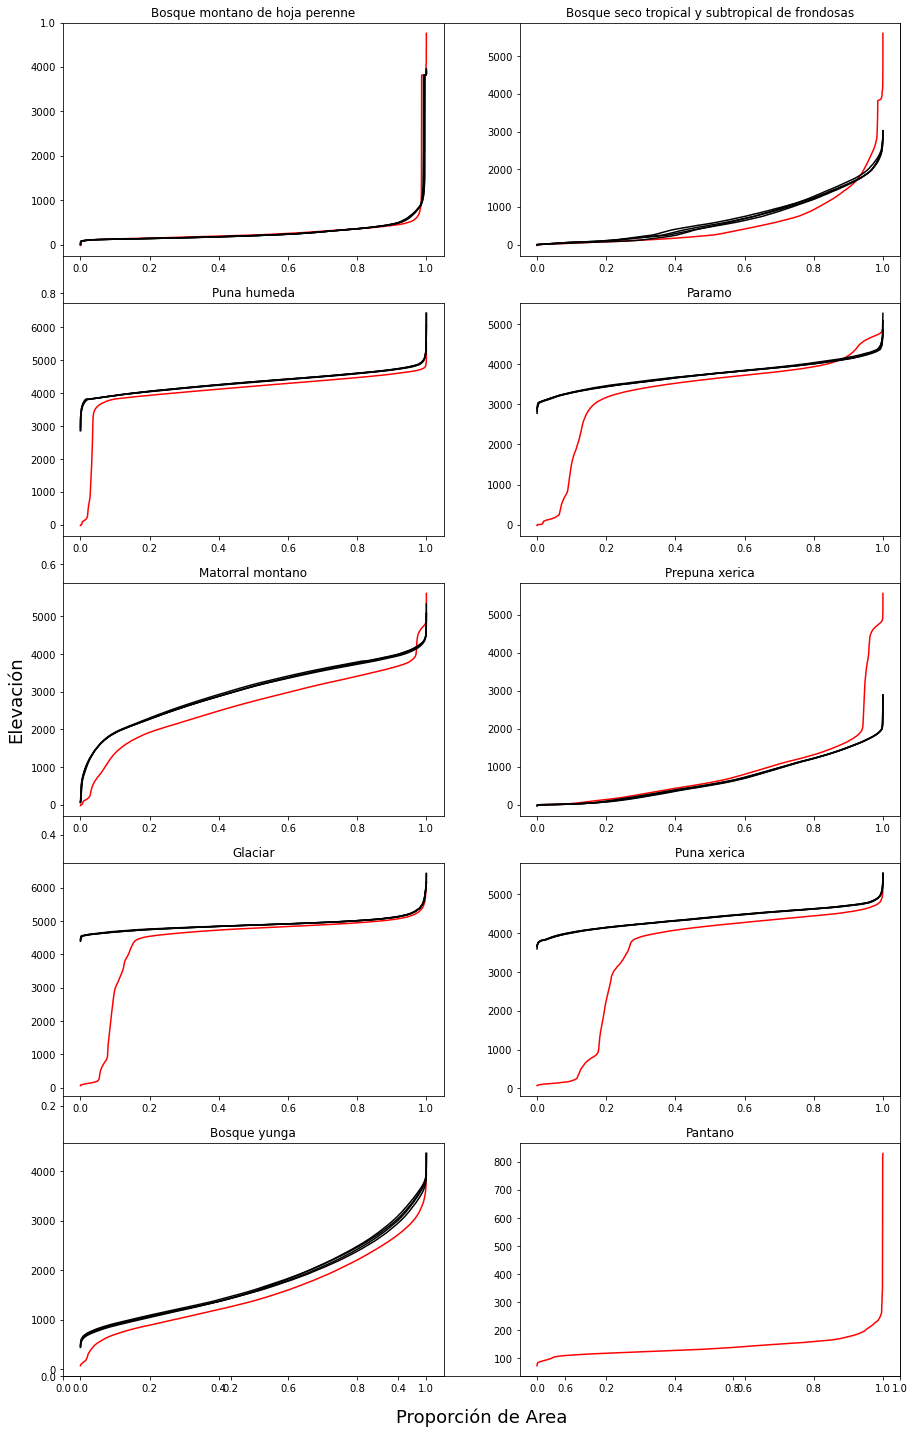

In [180]:
fig = plt.figure(figsize=(15,10))
plt.ylabel('Elevación',labelpad=15,fontsize=18)
plt.xlabel('Proporción de Area',labelpad=15,fontsize=18)
plt.subplots_adjust(bottom = -1)
for i,bio in enumerate(tar_names.keys()):
    ax = fig.add_subplot(5, 2, i+1)
    for col in columns:
        filtro=ComparisonDF[ComparisonDF[col]==bio]
        filtro=filtro.sort_values(by=['z'])
        n=filtro.shape[0]
        filtro['Area']=np.arange(1,n+1,1)/n
        
        if col=='model_present':
            im=ax.plot(filtro.Area,filtro.z,'red')
        else:
            im=ax.plot(filtro.Area,filtro.z,'black')
        
    
    ax.set_title(tar_names[bio])
    
fig.savefig('C:/Users/joseZ/Dropbox/BIOMAS_25_Meses/Informes/informe5/Imagenes/Elevation.png', format='png', dpi=1200,bbox_inches='tight')

In [181]:
def BiomeChange(Comparison,name,n=8):
    # n is the number of the biome  a evaluate
    #the function returns 2 data frames
    #the first show the stable and where the biome migrate
    #the second show where the biome wins area
    
    filtro=Comparison[Comparison['model_present']==n]
    #growth=Comparison[Comparison[name]==n]
    
    MatList=[]
    def Variations(filtro,column):
        change=filtro[column].value_counts().to_dict()
        if 0 in change.keys():
            del change[0]
        percentage_change=[np.round(change[i]*100/np.sum(list(change.values())),2) for i in change.keys()]
        area=[np.round(change[i]*1.02,2) for i in change.keys()]
        
        #result=pd.DataFrame({'Biomes':list(change.keys()),'Area Km2':area,'Percentage %':percentage_change})
        #result.Biomes=result.Biomes.map(tar_names)
        result={'Biomes':list(change.keys()),'Area Km2':area,'Percentage':percentage_change}
        return result
    
    return Variations(filtro,name)

In [182]:
GCMs=[]
#columns.remove('model_present')
for model in columns:
    transformation=np.zeros((14,14))
    for biomes in np.arange(1,14,1):
        ff=BiomeChange(ComparisonDF,model,biomes)
        col_idx=[x-1 for x in ff['Biomes'] ]
        transformation[biomes-1,col_idx]=ff['Percentage']

    GCMs.append(pd.DataFrame(transformation))

In [183]:
GCM_Pred=np.stack(GCMs)
MediaResult=np.zeros((14,14))
for i in range(0,14):
    for j in range(0,14):
        MediaResult[i,j]=np.median(GCM_Pred[:,i,j])

In [184]:
MediaResult=pd.DataFrame(MediaResult)

In [185]:
MediaResult.columns=np.arange(1,15,1)
MediaResult.index=np.arange(1,15,1)
MediaResult.columns=MediaResult.columns.map(tar_names)
MediaResult.index=MediaResult.index.map(tar_names)

In [186]:
MediaResult.loc[tar_names.values(),tar_names.values()]

,Bosque montano de hoja perenne,Bosque seco tropical y subtropical de frondosas,Puna humeda,Paramo,Matorral montano,Prepuna xerica,Glaciar,Puna xerica,Bosque yunga,Pantano
Bosque montano de hoja perenne,98.66,0.21,0.46,0.00,0.05,0.06,0.00,0.02,0.29,0.0
Bosque seco tropical y subtropical de frondosas,21.38,59.38,1.09,0.04,6.00,11.08,0.00,0.06,0.67,0.0
Puna humeda,2.08,0.50,76.90,1.24,16.27,0.33,0.43,1.12,0.86,0.0
Paramo,6.00,2.33,11.99,19.01,46.45,1.36,0.49,0.29,11.20,0.0
Matorral montano,2.23,1.99,2.97,0.26,83.84,5.50,0.19,0.31,2.47,0.0
Prepuna xerica,2.89,0.65,3.51,0.05,2.51,88.82,0.41,0.24,0.87,0.0
Glaciar,7.03,0.38,35.74,0.46,2.85,0.00,37.04,13.58,2.84,0.0
Puna xerica,15.64,0.59,7.26,0.17,9.99,0.00,0.92,57.65,6.22,0.0
Bosque yunga,17.08,0.85,0.10,0.28,4.71,0.03,0.00,0.00,75.63,0.0
Pantano,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
